## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("./ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

b. Use the below cell to find the number of rows in the dataset.

In [5]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [6]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [7]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [8]:
df[(df['landing_page'] == 'old_page') & (df['group'] == 'treatment') | (df['landing_page'] == 'new_page') & (df['group'] == 'control')].count()['user_id'] 

3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum(axis=0)

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
df2 = df.drop(df[(df['landing_page'] == 'old_page') & (df['group'] == 'treatment') | (df['landing_page'] == 'new_page') & (df['group'] == 'control')].index)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.duplicated('user_id', keep=False)]['user_id'].unique()

array([773192])

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop(index=df2[df2.duplicated('user_id')].index, inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
print(df2[(df2['group'] == 'control')]['converted'].mean())

0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
print(df2[(df2['group'] == 'treatment')]['converted'].mean())

0.11880806551510564


d. What is the probability that an individual received the new page?

In [19]:
round(df2[(df2['landing_page'] == 'new_page')].shape[0]/df2.shape[0],4)

0.5001

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

- the probability of an individual converting: `0.119`.
- the probability of a control group converted: `0.1203`.
- the probability of a treatment group converted: `0.1188`.
- the probability that an individual received the new page: `0.5001`.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

 $$H_{0}: p_{new} - p_{old} <= 0$$
 $$H_{1}: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


In [22]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [23]:
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [24]:
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.binomial(n_new,p_new)
new_page_converted

17270

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(n_old,p_old)
old_page_converted

17319

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
(new_page_converted/ n_new) - (old_page_converted / n_old)

-0.0003667454385212071

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([   6.,   49.,  420., 1462., 3037., 2874., 1635.,  439.,   70.,
           8.]),
 array([-4.99891535e-03, -3.99817678e-03, -2.99743821e-03, -1.99669964e-03,
        -9.95961066e-04,  4.77750464e-06,  1.00551608e-03,  2.00625465e-03,
         3.00699322e-03,  4.00773179e-03,  5.00847036e-03]),
 <a list of 10 Patch objects>)

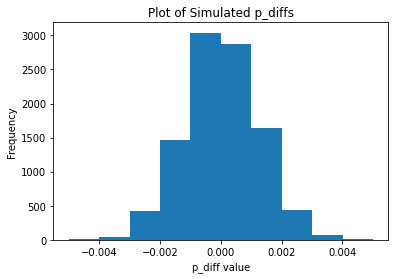

In [29]:
plt.xlabel('p_diff value')
plt.ylabel('Frequency')
plt.title('Plot of Simulated p_diffs');
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
p_diff_orig = df[df['landing_page'] == 'new_page']['converted'].mean() -  df[df['landing_page'] == 'old_page']['converted'].mean()
p_diff_orig

-0.0016367945992569882

In [31]:
p_diffs = np.array(p_diffs)
p_diff_proportion = (p_diff_orig < p_diffs).mean()
p_diff_proportion

0.9179

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**We calculate the p-Value. if the null hypothesis is correct, it means that the observed statistic on the new page is not more efficient than the old page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = sum(df2.query("landing_page == 'old_page'")['converted'])
convert_new = sum(df2.query("landing_page == 'new_page'")['converted'])
n_old = len(df2.query("landing_page == 'old_page'"))
n_new = len(df2.query("landing_page == 'new_page'"))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, pval = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
print(round(z_score,3))
print(round(pval,3))

1.311
0.19


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [34]:
from scipy.stats import norm
# significant of z-score
print(round(norm.cdf(z_score), 3))

# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(round(norm.ppf(1-(0.05)), 3))

0.905
1.645


In statistics, the standard score is the number of standard deviations by which the value of a raw score (i.e., an observed value or data point) is above or below the mean value of what is being observed or measured. Raw scores above the mean have positive standard scores, while those below the mean have negative standard scores. 

$$Z_{score} = (x – μ) / σ$$


<br>
<br>


We find that the z-score of `1.311` is less than the critical value of `1.645` which means we can't **reject the null hypothesis**


We find that old page conversions are slightly better than new page conversions. Eventhough the values are different from findings in parts j. and k but it suggests there is no significant difference between old page and new page conversions.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**


b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2['intercept'] = 1
df2[['control', 'ab_page']]=pd.get_dummies(df2['group'])
df2.drop(labels=['control'], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [123]:
import statsmodels.api as sm
import scipy.stats as stats
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

logit = sm.Logit(df2['converted'],df2[['intercept' ,'ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-05-02 11:45 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [124]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-05-02 11:45 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**p-value is 0.19 .The p-value here suggests that that new page is not statistically significant as 0.19 > 0.05 . In this section it was a two-sided t-test compared to a one-sided t-test in part II.Here we test for not equal in our hypotheses whereas in Part II it was for different.**


Hypothesis in Part III ::

$$H_{0} : p_{new} - p_{old} = 0$$

$$H_{1} : p_{new} - p_{old} \neq 0$$

Hypothesis in Part II ::

$$H_{0} : p_{new} <= p_{old}$$

$$H_{1} : p_{new} > p_{old}$$



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**There might be many factors that can effect individual converts, for example, age group and gender can play a significant change. Also the conversion's rate may effect a access e usage, besides mentioning that one of the problems that can arise when considering other additional factors may be the multicollinearity. We can find new trends using other factors but there may be some disadvantages like even with new factors we may miss some other influencing factors which lead to unreliable and contradictory results compared to previous results**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [128]:
### Create the necessary dummy variables
df_new[['CA','UK','US']]=pd.get_dummies(df_new['country'])
df_new.head(1)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,ab_UK,ab_US
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0


In [126]:
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
results = mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-05-02 11:46 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

In [55]:
np.exp(results.params)

intercept    0.135779
CA           0.960018
UK           1.009966
dtype: float64

In [133]:
1/np.exp(results.params)

intercept    7.418713
ab_page      1.069775
UK           0.988285
US           0.982625
ab_UK        0.924703
ab_US        0.954198
dtype: float64

**If an individual living in the CA country, it is 1.04 more likely to be converted than to die in the US, keeping all other variables constant.**

**If an individual living in the UK country is 1 more likely to be converted than to die in the US, keeping all other variables constant.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [129]:
df_new['ab_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_US'] = df_new['ab_page'] * df_new['US']
lm3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK' , 'US', 'ab_UK', 'ab_US']])
results = lm3.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 02 May 2021   Pseudo R-squ.:               3.482e-05
Time:                        11:47:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_UK          0.0783      0.057      1.378      0.168      -0.033       0.190
ab_US          0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

In [132]:
np.exp(results.params)

intercept    0.134794
ab_page      0.934776
UK           1.011854
US           1.017682
ab_UK        1.081428
ab_US        1.048001
dtype: float64

**For each increase of a point in the interaction between country and page, an individual is 1.08 more likely to be converted, keeping all other variables constant, we can verify through the P-value that the conversion is statistically insignificant, due to the p -value to be greater than 5%, in most explanatory variables, accepting the null hypothesis. With the objective of verifying an interaction between the explanatory variables that we will perform the calculation of VIF (Variance Inflation Factor) below:**



### Run a multiple regression

In [130]:
features = "+".join(df_new[['ab_page', 'CA', 'UK', 'US', 'ab_UK', 'ab_US']].columns)
features

'ab_page+CA+UK+US+ab_UK+ab_US'

### Calculate VIF Factors

In [131]:
# get y and X dataframes based on this regression:


vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

/home/renato/ENV/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/renato/ENV/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


### Inspect the factors for each predictor variable, if the VIF is between 5-10, multicolinearity is likely present and you should consider dropping the variable.

In [122]:
vif.round(1)

,VIF Factor,features
0,0.0,Intercept
1,20.0,ab_page
2,inf,CA
3,inf,UK
4,inf,US
5,10.5,ab_UK
6,19.6,ab_US


### VIF's Results

As presented in [Variance Inflation Factor (VIF) Explained](https://etav.github.io/python/vif_factor_python.html), we look for variables between five and ten. If the variables are outside this range it is important not to perform with inference.
It was verified in the calculation of VIF previously, it is not possible an interaction between these variables (countries and page). 

<a id='conclusions'></a>
## Conclusions

From the information provided in the data set on the implementation of a new page, we inform that we accept the null hypothesis, because the analysis showed that there was no significant difference in the statistics performed, justifying the continuity of the old page.